# Identifying Pneumonina using Convolutional Neural Networks

- Student Name: Kevin Spring
- Student pace: Flex
- Scheduled Project Review: December 12, 2022
- Instructor name: Morgan Jones
- Blog Post

# Summary


# Table of Contents

# Introduction

# Methodology

## Data

In [1]:
# Steps:
# 1. Load data
# 2. Look at sample image and label

# The data is in 
import os, shutil
PATH = os.path.join(os.path.abspath(os.getcwd()),'data')

In [2]:
PATH

'D:\\Documents\\GitHub\\flatiron-data-science\\phase04\\project\\Pneumonia-detection-using-CNN\\data'

In [9]:
train_dir = os.path.join(PATH, 'train\\')
val_dir = os.path.join(PATH, 'val\\')
test_dir = os.path.join(PATH, 'test\\')

train_normal = os.path.join(train_dir, 'NORMAL\\')
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA\\')


1341
normal picture title:  NORMAL2-IM-0946-0001.jpeg
pneumonia picture title: person1465_virus_2537.jpeg


Text(0.5, 1.0, 'Pneumonia')

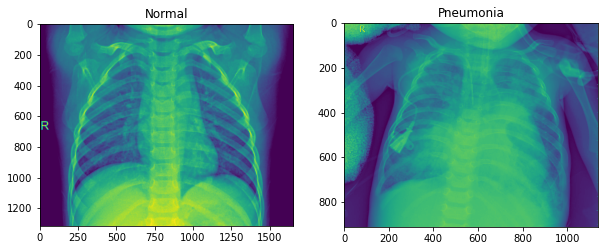

In [15]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print(len(os.listdir(train_normal)))
rand_norm = np.random.randint(0, len(os.listdir(train_normal)))
norm_img = os.listdir(train_normal)[rand_norm]
print('normal picture title: ', norm_img)
norm_img_address = train_normal+norm_img

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_pneumonia)))

pneu_img =  os.listdir(train_pneumonia)[rand_norm]
pneu_img_address = train_pneumonia+pneu_img
print('pneumonia picture title:', pneu_img)

# Load the image
norm_load = Image.open(norm_img_address)
pneu_load = Image.open(pneu_img_address)

# Show the picture
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
ax1.set_title('Normal')

ax2 = fig.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneu_load)
ax2.set_title('Pneumonia')

In [17]:
from keras.preprocessing.image import ImageDataGenerator#, array_to_img, img_to_array, load_img

# get all the data in the directory strain, and reshape them
train_imggen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_imggen = ImageDataGenerator(rescale = 1./255)  #Image normalization

training_set = train_imggen.flow_from_directory(train_dir,
                                                target_size = (64, 64),
                                                batch_size = 32,
                                                class_mode = 'binary')

validation_set = test_imggen.flow_from_directory(val_dir,
                                                 target_size=(64,64),
                                                 batch_size=32,
                                                 class_mode='binary')

test_set = test_imggen.flow_from_directory(test_dir,
                                           target_size=(64,64),
                                           batch_size=32,
                                           class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:
# baseline CNN model
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

cnn = Sequential()

#Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))

#Pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu"))

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected Layers
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Summary
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [24]:
# Fit the model to the data
#num_of_test_samples = 600
#batch_size = 32

cnn_model = cnn.fit(training_set,
                    steps_per_epoch = 163,
                    epochs=1,
                    validation_data = validation_set,
                    validation_steps=624)

163/163 [==============================] - 187s 1s/step - loss: 0.2733 - accuracy: 0.8867 - val_loss: 0.4325 - val_accuracy: 0.8125


In [26]:
test_accu = cnn.evaluate(test_set,steps=624)
print('The testing accuracy is :',test_accu[1]*100, '%')

624/624 [==============================] - 9s 13ms/step - loss: 0.3546 - accuracy: 0.8397
The testing accuracy is : 83.97436141967773 %
